In [1]:
## Find out what GPU we got (and make sure we actually have one!)
!nvidia-smi

Wed Jun 21 22:11:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
## Download all the data! This may take a little while...

## Processed data
try:
    import google.colab
    IN_COLAB = True
    !wget https://www.dropbox.com/s/la05h49y9ths7x3/autoseg_data.tar.gz?dl=0 -O /content/AllProcessedData.tar
    !tar -xf /content/AllProcessedData.tar -C /content/
    !rm /content/AllProcessedData.tar
except:
    IN_COLAB = False
    !wget https://www.dropbox.com/s/la05h49y9ths7x3/autoseg_data.tar.gz?dl=0 -O ./AllProcessedData.tar
    !tar -xf ./AllProcessedData.tar -C ./
    !rm AllProcessedData.tar

# utilities python file
if IN_COLAB:
    !wget https://www.dropbox.com/s/rng7h9mgkwaolt8/utils.py?dl=0 -O /content/utils.py
else:
    !wget https://www.dropbox.com/s/rng7h9mgkwaolt8/utils.py?dl=0 -O ./utils.py

--2023-06-21 22:12:16--  https://www.dropbox.com/s/la05h49y9ths7x3/autoseg_data.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.71.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.71.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/la05h49y9ths7x3/autoseg_data.tar.gz [following]
--2023-06-21 22:12:16--  https://www.dropbox.com/s/raw/la05h49y9ths7x3/autoseg_data.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc760734c0b800a2b230284f5acd.dl.dropboxusercontent.com/cd/0/inline/B-bnZK9DrbMMlPf0TtgaoynZVH0z2L8H46ScziRbZ0GzW0jOXrX_fwgUHaB2wPCXKEladCz7KvoXhvmT9CVKp2Wgmaev1ijs9beiIVq8B5g7f-2mpKAZRIcH0pAQOquAwwZUPgotkWSosCJQRqkLp-eegfaE--b6LFaScNBaQEODog/file# [following]
--2023-06-21 22:12:16--  https://uc760734c0b800a2b230284f5acd.dl.dropboxusercontent.com/cd/0/inline/B-bnZK9DrbMMlPf0TtgaoynZVH0z2L8H46ScziRbZ0GzW0jOXrX

## 0. Install prerequisites

Here we install the pytorch flavour of the segmentation-models library, along with pydicom and pytorch-lightning

In [3]:
if IN_COLAB:
    %pip install git+https://github.com/qubvel/segmentation_models.pytorch
    %pip install pytorch_lightning tqdm ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-b890u6p9
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-b890u6p9
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e5d3db20e9c2ddb76f88642409e527239943c983
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.9 MB/s eta 0:00:00
  Created wheel f

## 0. Set up monitoring and enable matplotlib notebook interactivity

In [4]:
%matplotlib inline
import tensorboard
%load_ext tensorboard

## 0. Load required libraries

In [5]:
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import albumentations as A
import numpy as np
# import pydicom
import torch
import os
from utils import getFiles
from os.path import join
import pickle
## These are the structures defined in the FLARE data
structure_names = ['Body', 'Brainstem', 'Mandible', 'Parotids', 'Spinalcord']
## See if we're in colab...
if IN_COLAB:
    datapath = "/content/HnN_data/"
else:
    datapath = "/home/ed/autoseg_workshop_2023/HnN_data/"  ## <---- You will need to change this if running locally

# 1. Load the HN data

In [13]:
## Get the training data
train_datapath = join(datapath, "train")
fnames = sorted(getFiles(join(train_datapath, 'ims')))
train_ct_slices = np.zeros((len(fnames), 192, 192), dtype=np.float32)
train_mask_slices = np.zeros((len(fnames), 192, 192), dtype=np.float32)


for fdx, fname in enumerate(fnames):
    train_ct_slices[fdx] = np.load(join(train_datapath, "ims", fname))
    train_mask_slices[fdx] = np.load(join(train_datapath, "masks", fname))

# load pixel spacing
with open(join(train_datapath, "spacings.pkl"), "rb") as f:
    train_pixel_sizes = pickle.load(f)


# Get the test data
test_datapath = join(datapath, "test")
fnames = sorted(getFiles(join(test_datapath, 'ims')))
test_ct_slices = np.zeros((len(fnames), 192, 192), dtype=np.float32)
test_mask_slices = np.zeros((len(fnames), 192, 192), dtype=np.float32)

for fdx, fname in enumerate(fnames):
    test_ct_slices[fdx] = np.load(join(test_datapath, "ims", fname))
    test_mask_slices[fdx] = np.load(join(test_datapath, "masks", fname))

# load pixel spacing
with open(join(test_datapath, "spacings.pkl"), "rb") as f:
    test_pixel_sizes = pickle.load(f)

print(train_ct_slices.shape)
print(train_mask_slices.shape)
print(test_ct_slices.shape)
print(test_mask_slices.shape)

(499, 192, 192)
(499, 192, 192)
(217, 192, 192)
(217, 192, 192)


# 2. Preprocessing

In [26]:
# your code here ...

def window_level(data, window=130, level=60):
    """
    Apply a window and level transformation to CT slices.

    The default values are taken taken from https://radiopaedia.org/articles/windowing-ct?lang=gb

    Pixel values will be in the range 0-1
    """
    ## calculate high & low edges of level & window
    low_edge  = level - (window//2)
    high_edge = level + (window//2)
    ## use np.clip to clip into that level/window, then adjust to range 0 - 1
    windowed_data = (np.clip(data, low_edge, high_edge) - low_edge)/window

    return windowed_data

We have a slightly smaller dataset of HnN data. Therefore we don't need to sample the data as heavily.

In [27]:
## Apply the preprocessing
window_levelled_slices_train = window_level(train_ct_slices)
window_levelled_slices_test = window_level(test_ct_slices)

## If you run out of RAM, you can save memory by deleting the original array - will need to re-load it if we change something
# del train_annotated_ct_slices
# del test_annotated_ct_slices

print(window_levelled_slices_train.shape)
print(window_levelled_slices_test.shape)

(499, 192, 192)
(217, 192, 192)


In [28]:
np.random.seed(1234)
subset_indices = np.random.permutation(window_levelled_slices_train.shape[0])

wl_slice_subset_train = window_levelled_slices_train[subset_indices[:400]]
mask_subset_train = train_mask_slices[subset_indices[:400]]
spacings_subset_train = np.array(list(train_pixel_sizes.values()))[subset_indices[:400]]

wl_slice_subset_val = window_levelled_slices_train[subset_indices[400:]]
mask_subset_val =  train_mask_slices[subset_indices[400:]]
spacings_subset_val = np.array(list(train_pixel_sizes.values()))[subset_indices[400:]]

np.random.seed()

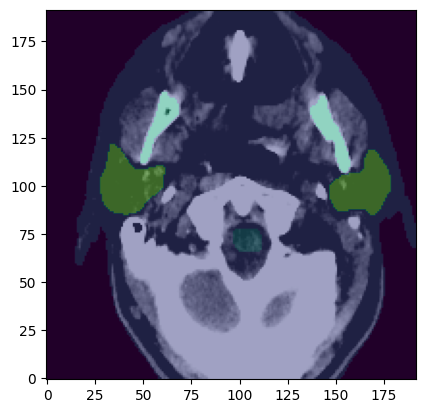

In [29]:
n=47
fig, ax = plt.subplots()
ax.imshow(window_levelled_slices_train[n,...], cmap='Greys_r')
ax.imshow(train_mask_slices[n,...].squeeze(), alpha=0.5, cmap='viridis', vmax=5)
ax.invert_yaxis()
plt.show()

In [ ]:
# add dataset code and dataloaders here ...

# 3. Creating the Segmentation model

In [ ]:
# add model code here ...

# 4. Training

In [ ]:
# add training code here ...

# 5. Evaluation

Let's now run the evaluation over the entire test set!

In [ ]:
# add testing code here ...

# 6. Visualisation

In [ ]:
fig, ax = plt.subplots()

### Your code here...